# Example: Tag-and-probe analysis

This is a complex example taken from particle physics how resampling can be used in practice. The actual call into the resample library is very simple, but the setup of the example is complex, since it involves a realistic analysis on toy data.

A tag-and-probe analysis in particle physcis can be used to obtain the selection efficiency for a cut applied to the products of a two-body decay with products that have the same mass. The purpose of the cut is to reduce the combinatorial background in the sample of decay candidates. For example, in the decay $\phi \to K^+K^-$, we can remove background if we have particle identification information, but applying a cut that favors kaons.

The efficiency for such a cut is obtained in the following way. The tag sample is generated by applying the cut only on one of the products. The probe sample is generated by applying the cut on both products. The background is strongly reduced in the probe sample and to a lesser degree in the tag sample.

Under the assumption that the cut efficiency for both products is equal, we can estimate the total number of decays from the signal reduction in the probe sample relative to the tag sample. For that, the peak in the mass distribution of the decay candidates has to be fitted in both the tag and probe samples. Since the probe sample is a subset of the tag sample and not independent, computing the statistical uncertainty for the efficiency and the final result is very challenging, as there are correlations to consider.

The bootstrap is an elegant solution to this problem, because it allows one to compute the statistical uncertainty for any complex estimator.

We generate some toy data in bins of transverse momentum, $p_T$. The efficiency of the cut on the kaon is 80 %.

In [26]:
import numpy as np
import boost_histogram as bh
import matplotlib.pyplot as plt
from iminuit import Minuit, cost
from numba_stats import truncnorm, truncexpon

a_pt = bh.axis.Regular(4, 0, 10, metadata="pt")


def fit(pt, mass_axis, val, var, showfig):
    mrange = mass_axis.edges[0], mass_axis.edges[-1]

    def model(x, ns, mu, sigma, nb, slope):
        s = ns * truncnorm.cdf(x, *mrange, mu, sigma)
        b = nb * truncexpon.cdf(x, *mrange, 0, slope)
        return s + b

    if showfig:
        fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True, constrained_layout=True)

    results = []
    for kind in range(2):
        mass_val = val[:, kind]
        mass_var = var[:, kind]
        ntot = np.sum(mass_val)
        nll = cost.ExtendedBinnedNLL(
            np.column_stack((mass_val, mass_var))
            if any(mass_val != mass_var)
            else mass_val,
            mass_axis.edges,
            model,
        )

        m = Minuit(nll, ns=ntot / 2, mu=0.5, sigma=0.1, nb=ntot / 2, slope=1)
        m.strategy = 0  # strategy 0 is sufficient, we don't need to compute Hessian
        m.limits["ns", "nb", "sigma"] = (0, None)
        m.limits["mu"] = (0, 1)
        m.limits["slope"] = (0, 2)
        m.migrad()
        results.append(m.values["ns"])

        if showfig:
            plt.sca(ax[kind])
            nll.visualize(m.values)
            plt.title(f"{['tag', 'probe'][kind]} $\\chi^2$/ndof = {m.fval:.1f}/{m.ndof}")

    if showfig:
        fig.suptitle(
            f"pT = [{pt[0]}, {pt[1]}) GeV/c"
        )
        fig.supxlabel("mass / GeV")

    return results


def fit_all(histogram, showfig=False):
    mass_axis = histogram.axes[1]
    val = histogram.values()
    var = histogram.variances()  # if events are weighted, we also need variances
    n_tag = np.empty(val.shape[0])
    n_probe = np.empty(val.shape[0])
    for i, (vali, vari, pti) in enumerate(zip(val, var, a_pt)):
        n_tag[i], n_probe[i] = fit(pti, mass_axis, vali, vari, showfig)
    return n_tag, n_probe


def trafo(inputs, showfig=False):
    h = bh.Histogram(
        a_pt,
        bh.axis.Regular(50, 0, 1, metadata="mass"),
        bh.axis.Integer(0, 2, metadata="tag|probe"),
    )

    pt, m, is_probe = inputs.T
    h.fill(pt, m, is_probe)

    n_tag, n_probe = fit_all(h, showfig)

    with np.errstate(invalid="ignore", divide="ignore"):
        eps_k = 2 * n_probe / (n_probe + n_tag)
        n_rec = (n_tag + n_probe) ** 2 / (4 * n_probe)

    return eps_k, n_rec


rng = np.random.default_rng(1)

# generate toy data
pt = rng.exponential(2, size=10000)
s = rng.normal(0.5, 0.1, size=len(pt) // 2)
b = rng.exponential(2, size=len(pt) - len(s))
mass = np.append(s, b)
# true if sample is in tag AND probe sets, false if only in tag set
eps_probe = 0.4
is_probe = rng.uniform(0, 1, size=len(pt)) < eps_probe

expected_eff_k = 2 * eps_probe / (eps_probe + (1 - eps_probe))

The actual bootstrapping is happening in the function `variance`.

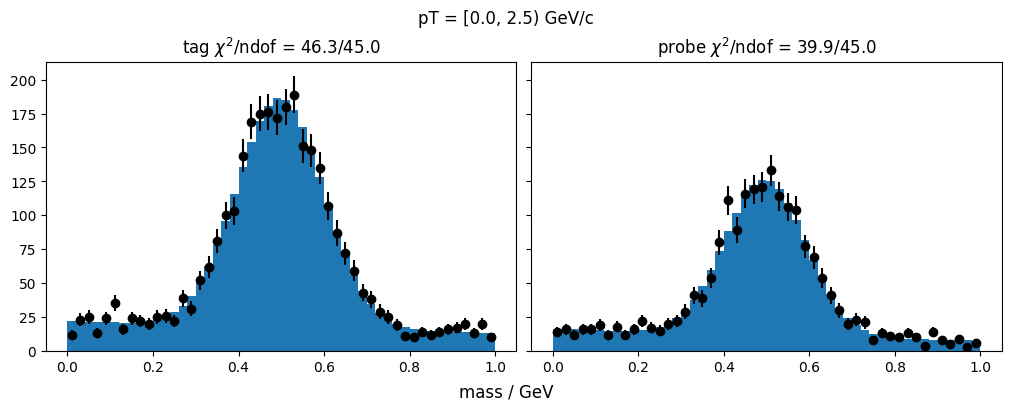

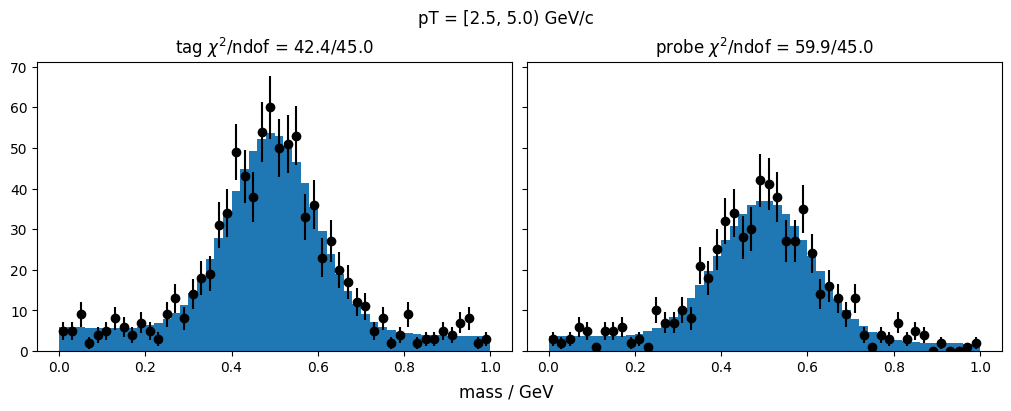

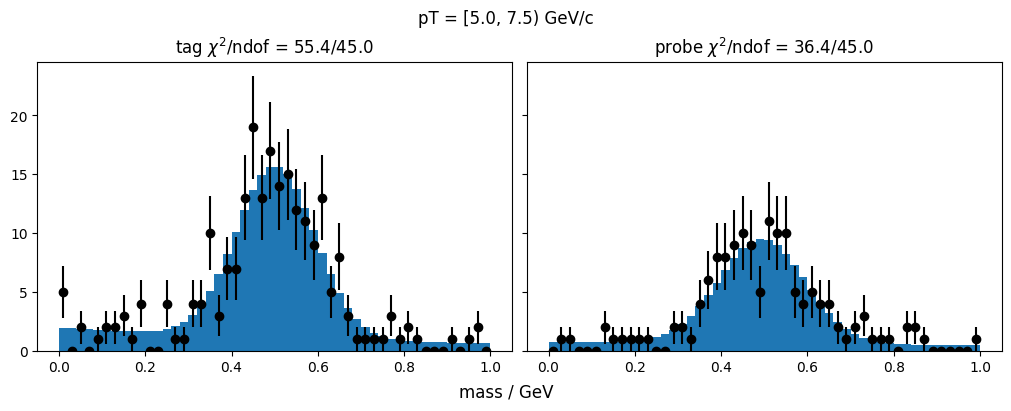

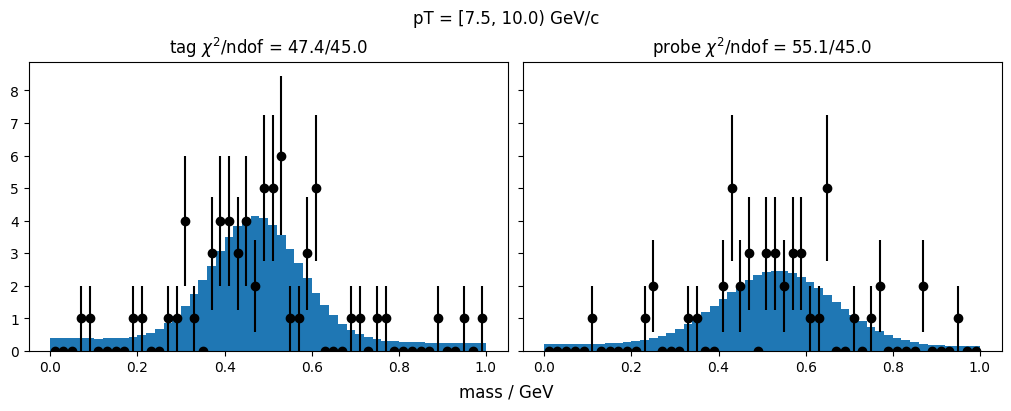

In [27]:
from resample.bootstrap import variance

# inputs must have shape (N, K), where N is the dimension in which the algorithm resamples
inputs = np.column_stack((pt, mass, is_probe))

# compute results for original data set
eps_k, n_rec = trafo(inputs, showfig=True)

# compute variance of results with resampled data sets
var_eps_k, var_n_rec = variance(trafo, inputs, size=10)

Plot the results.

Text(0, 0.5, 'kaon efficiency')

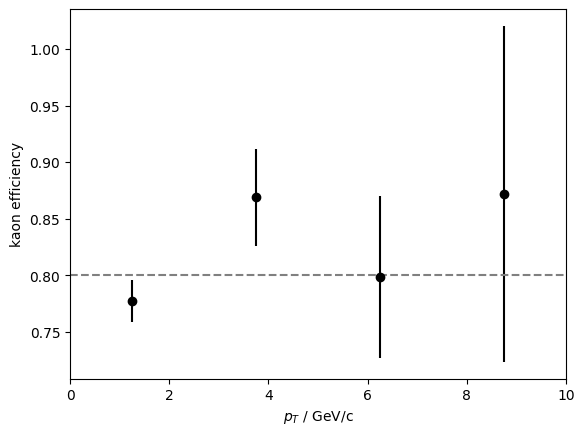

In [28]:
plt.figure()
plt.xlim(a_pt.edges[0], a_pt.edges[-1])
plt.errorbar(a_pt.centers, eps_k, var_eps_k ** 0.5, fmt="ok")
plt.axhline(expected_eff_k, ls="--", color="0.5")
plt.xlabel("$p_T$ / GeV/c")
plt.ylabel("kaon efficiency")